# Лабораторная №1. Задача регрессии.

**Шкуратова Д.В. Б9122-01.03.02мкт**


# Import

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import display

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load Dataset
Датасет взят с [Kaggle](https://www.kaggle.com/competitions/critical-temperature-of-superconductors/overview) (Задача с Samsung Innovation Campus Bootcamp)

**Описание задачи:**
>Явление сверхпроводимость одно из самых удивительных по своей природе, но объяснить его с классической точки зрения невозможно.
Данное явление было открыто голландским физиком Хейке Камерлинг-Оннес в 1911 году.

>Сверхпроводимость — свойство некоторых веществ и материалов, электрическое сопротивление которых при понижении температуры до определенного уровня падает до нуля. Сверхпроводимость возникает скачком при понижении температуры. Температура при которой возникает скачок называется критической температурой.

>Несмотря на то, что сверхпроводимость была открыта больше века назад, многие её свойства плохо изучены, например, связь между сверхпроводимостью и химическими/структурными свойствами материалов.

>Вам предлагается разработать алгоритмы машинного обучения, которые позволяют установить связь между химическим составом, различными свойствами сверхпроводниками и их критической температурой.


In [3]:
df = pd.read_csv('data/train.csv')
formula = pd.read_csv('data/formula_train.csv')
phys_cols = df.columns
chem_cols = formula.columns
formula.drop(columns=['critical_temp'], inplace=True)
df = pd.concat([df, formula], axis=1)
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,material
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Ba0.3La1.7Cu1O4


In [5]:
formula.shape[1], df.shape[1] - formula.shape[1]

(87, 82)

# DA
Тренировочный датасет состоит из двух csv файлов:
- formula_train.csv
    - содержит химическую формулу сверхпроводника: колонки являются названиями хим. эл-в, строки содержат кол-во атомов соответствюшего эл-та
- train.csv 
    - содержит другие химические и физические свойства сверхпроводника

<Axes: xlabel='critical_temp', ylabel='Count'>

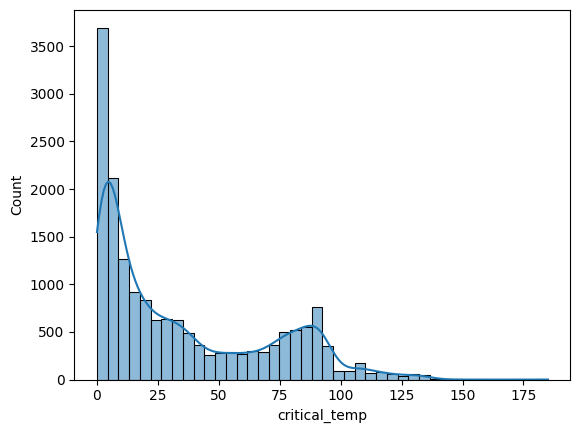

In [6]:
sns.histplot(df['critical_temp'], kde=True)

Для аналитического решения поиска коэффициентов линейной модели нужно удалить все высококоррелированные признаки и признаки равные нулевому вектору

In [8]:
df.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
count,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,...,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.000000,17010.0,17010.0,17010.0
mean,4.113874,87.534919,73.000381,71.308789,58.599393,1.165500,1.063972,115.443468,33.228642,44.320187,...,0.061441,0.035000,0.023379,0.036708,0.049646,0.042367,0.200175,0.0,0.0,0.0
std,1.437846,29.786319,33.730910,31.166777,36.902657,0.364607,0.401877,54.614167,27.104426,19.993413,...,0.872817,0.310635,0.800146,0.205809,0.279357,0.286488,0.656456,0.0,0.0,0.0
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,3.000000,72.383174,52.078254,58.001648,35.228269,0.966676,0.777721,78.353150,16.790394,32.890369,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,4.000000,84.841880,60.547264,66.361592,39.821155,1.199541,1.148646,122.906070,26.585389,45.123500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
75%,5.000000,100.404410,85.982586,78.116681,73.075297,1.444537,1.359836,154.119320,38.193007,58.973428,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,45.000000,5.000000,64.000000,8.000000,7.000000,19.000000,14.000000,0.0,0.0,0.0


In [10]:
df.drop(columns=['material'])
df['critical_temp'].describe()

count    17010.000000
mean        34.502993
std         34.334793
min          0.000210
25%          5.330000
50%         20.000000
75%         63.000000
max        185.000000
Name: critical_temp, dtype: float64

Рассмотрим распределения значений хим. эле-в по колонкам

In [28]:
formula.drop(columns=['material'], inplace=True)

In [31]:
pd.concat([formula.apply(lambda x: x.nunique()).to_frame('nunique'), 
           formula.apply(lambda x: x.min()).to_frame('min'),
           formula.apply(lambda x: x.quantile(0.25)).to_frame('Q25'),
           formula.apply(lambda x: x.quantile(0.5)).to_frame('Q50'),
           formula.apply(lambda x: x.quantile(0.75)).to_frame('Q75'),
           formula.apply(lambda x: x.max()).to_frame('max')], axis=1)
         

,nunique,min,Q25,Q50,Q75,max
H,106,0.0,0.0,0.0,0.0,14.0
He,1,0.0,0.0,0.0,0.0,0.0
Li,64,0.0,0.0,0.0,0.0,2.6
Be,40,0.0,0.0,0.0,0.0,40.0
B,92,0.0,0.0,0.0,0.0,105.0
...,...,...,...,...,...,...
Pb,142,0.0,0.0,0.0,0.0,19.0
Bi,144,0.0,0.0,0.0,0.0,14.0
Po,1,0.0,0.0,0.0,0.0,0.0
At,1,0.0,0.0,0.0,0.0,0.0


По значениям квартилей, минимальному и максимальному значению видим, что элементы, редко встречающиеся в составе материлов, есть элементы которые не встречаются совсе.
Удалим колонки содержащие нулевые столбцы

In [34]:
df = df.loc[:, ~df.eq(0).all()].drop(columns=['material'])

In [36]:
df.shape

(17010, 159)

В датасете все признаки вещественные, но есть колонка с кол-м элементов, содержащихся в материале, проверим не является ли она константой 

<Axes: xlabel='number_of_elements', ylabel='count'>

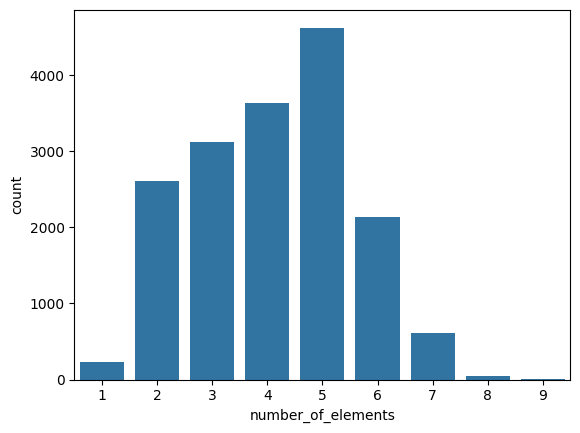

In [37]:
sns.countplot(df, x='number_of_elements')

В нашем датасете очень большое кол-во признаков, рассмотри корреляцию с целевой переменной, так как колонки с хим. элементам принимают только целочисленные значения, рассмотрим коэффициент с колонками из первой таблицы с физ. характеристиками

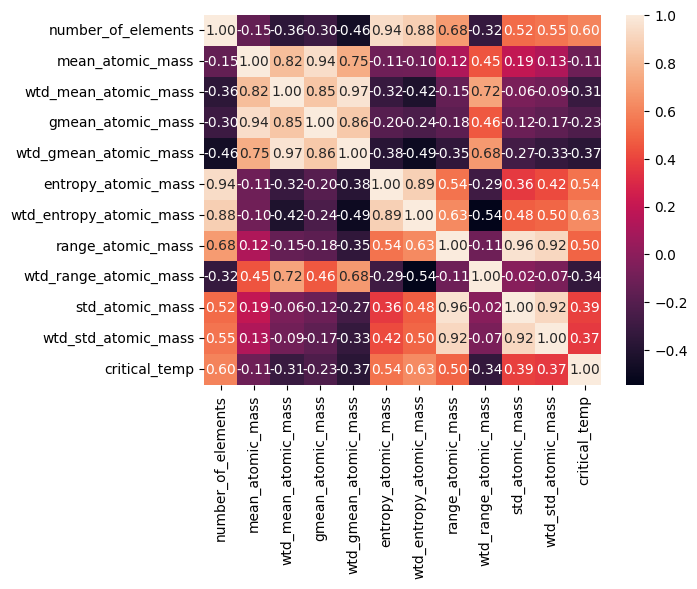

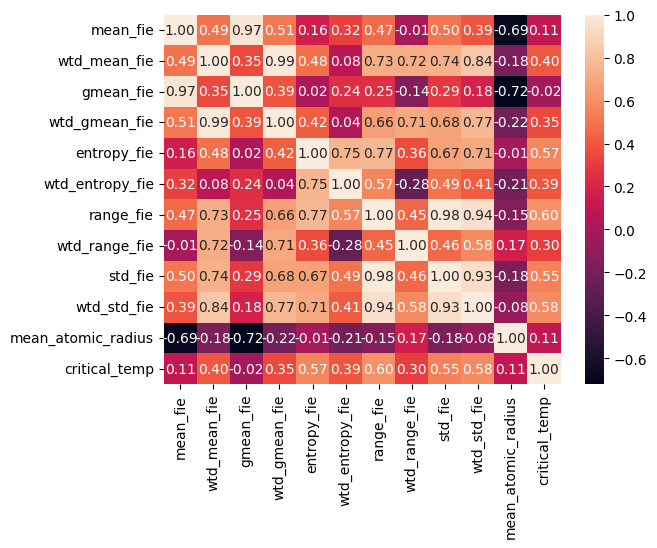

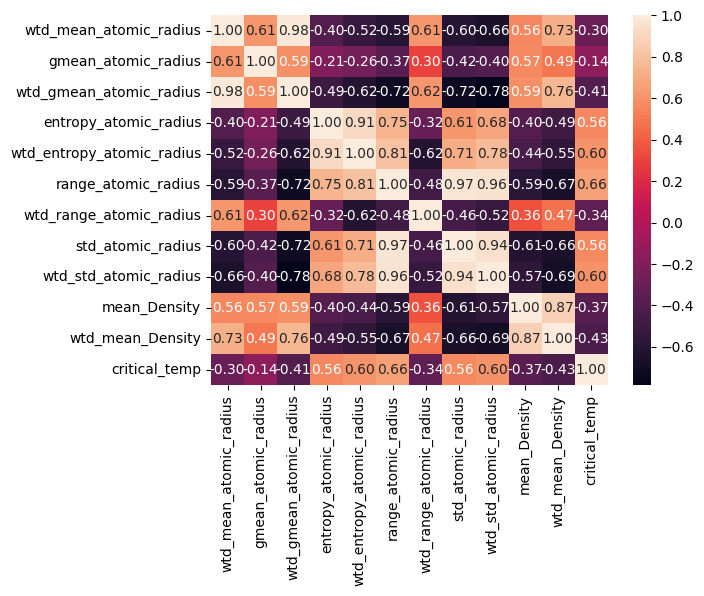

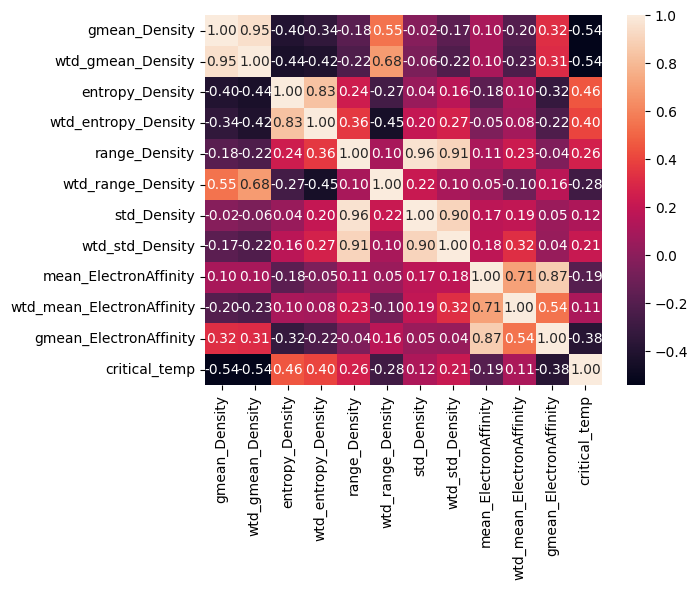

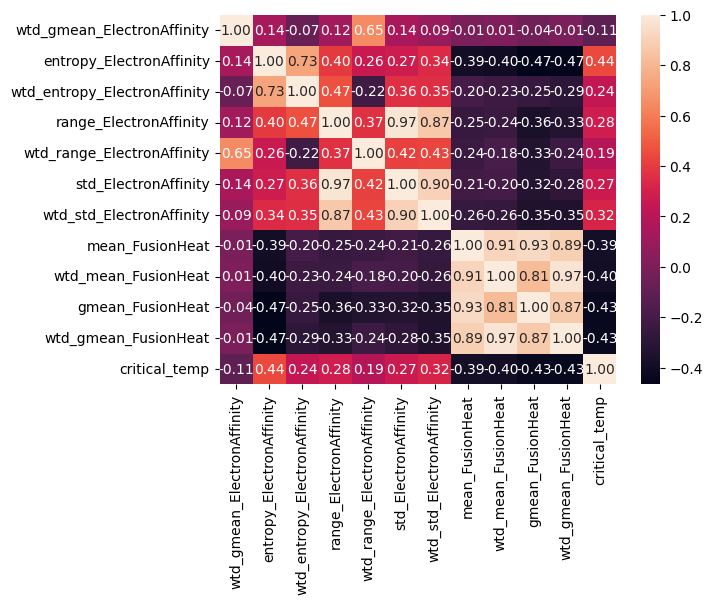

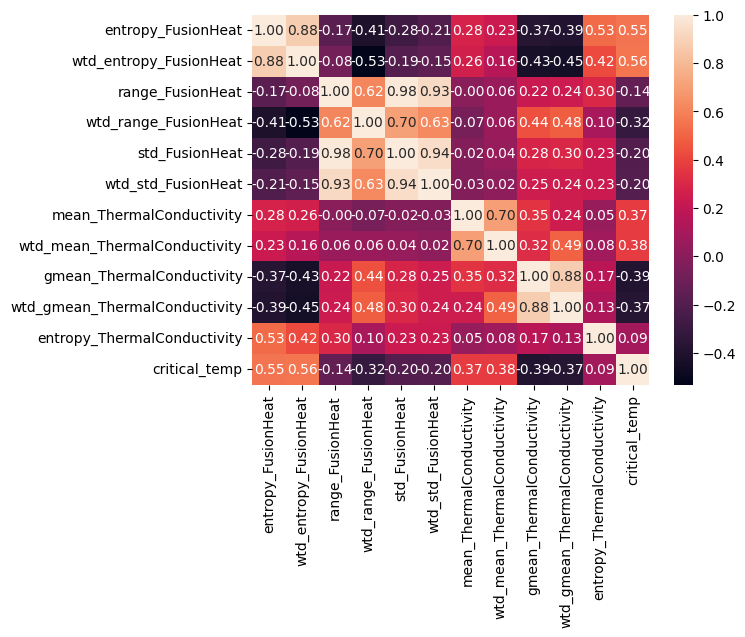

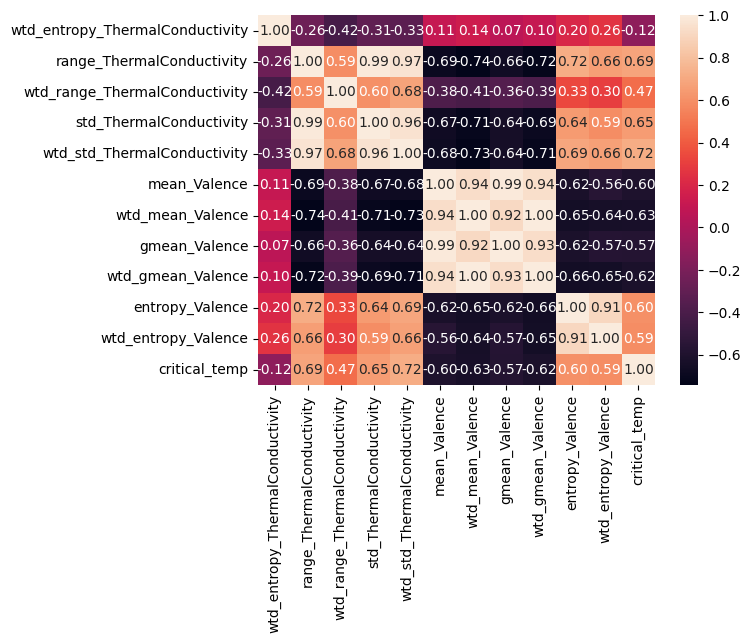

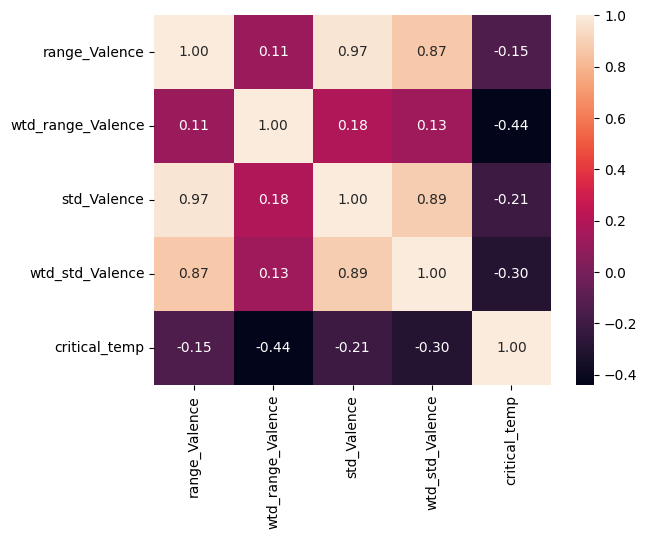

In [38]:
phys_cols = phys_cols.drop(['critical_temp']).to_list()
for i in range(0, len(phys_cols), 11):
    sns.heatmap(df[phys_cols[i:i +11] + ['critical_temp']].corr(numeric_only=True), annot=True, fmt='.2f')
    plt.show()

Получили, что целевая переменная имеет коэффициент корреляции > 0.5 с большим кол-м наблюдаемых признаков
Но для построения линейной регрессии мы должны убедиться, что все нецелевые признаки не имеют высокую попарную корреляцию
По выведеным срезам признаков видим, что это не там, матрица будет близка к вырожденной. 
Проверим получится ли воспользоваться аналитической формулой линейной регрессии, если нет, то будет фильтровать признаки по коэффициенту корреляции пока не получим коэффициенты весов. 

In [40]:
class MyLinReg:
    def __init__(self,  intercept=True):
        self.intercept = intercept
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        if self.intercept:
            X['Intercept'] = np.ones(X.shape[0])
        self.features = X.columns
        self.X = X.values
        self.y = y.values 
        try:
            self.w = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y 
            return pd.DataFrame({'features':self.features, 'coef':self.w})
        except np.linalg.LinAlgError as e:
            print(f"Error: {e}")
        
    def predict(self, X):
        if self.intercept:
            X['Intercept'] = np.ones(X.shape[0])
        return X[self.features].values @ self.w 

        

In [43]:
def get_metric(y_true, y_pred, filter=False):
    if filter:
        y_pred = [0 if i < 0 else i for i in y_pred]
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** (1/2)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return pd.DataFrame({
        'MSE':[mse],
        'RMSE':[rmse],
        'MAE':[mae],
        'R2':[r2]
    })


# Models

In [ ]:
class MyLinReg:
    def __init__(self,  intercept=True):
        self.intercept = intercept
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        if self.intercept:
            X['Intercept'] = np.ones(X.shape[0])
        self.features = X.columns
        self.X = X.values
        self.y = y.values 
        try:
            self.w = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.y 
            return pd.DataFrame({'features':self.features, 'coef':self.w})
        except np.linalg.LinAlgError as e:
            print(f"Error: {e}")
        
    def predict(self, X):
        if self.intercept:
            X['Intercept'] = np.ones(X.shape[0])
        return X[self.features].values @ self.w 

        

## Data preprocessing

In [56]:
corr_df = df[df.columns.drop('critical_temp')].corr(numeric_only=True)
corr_df.loc[:, (corr_df.abs() >= 0.7).any()]

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi
number_of_elements,1.000000,-0.147017,-0.359589,-0.297780,-0.460153,0.939359,0.882156,0.684415,-0.324029,0.517613,...,-0.052130,-0.044670,-0.056021,-0.049817,-0.039472,-0.027557,0.111363,0.113434,0.058097,0.245049
mean_atomic_mass,-0.147017,1.000000,0.817031,0.941275,0.748241,-0.109166,-0.102214,0.123012,0.449137,0.193848,...,0.052349,0.062808,0.130794,0.087441,0.112087,0.056326,0.103446,0.116263,0.190016,0.123422
wtd_mean_atomic_mass,-0.359589,0.817031,1.000000,0.848527,0.965004,-0.315194,-0.417680,-0.145627,0.719892,-0.061539,...,0.065650,0.083175,0.121650,0.096792,0.115072,0.069147,0.041288,0.059139,0.168425,0.117003
gmean_atomic_mass,-0.297780,0.941275,0.848527,1.000000,0.856949,-0.196480,-0.236936,-0.175981,0.461018,-0.121441,...,0.019990,0.060222,0.134243,0.072807,0.096922,0.058219,0.034598,0.062819,0.163556,0.037827
wtd_gmean_atomic_mass,-0.460153,0.748241,0.965004,0.856949,1.000000,-0.377961,-0.489958,-0.350984,0.677883,-0.272322,...,0.041111,0.079704,0.118154,0.073576,0.096406,0.067551,-0.002531,0.021144,0.148240,0.032348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Au,-0.027557,0.056326,0.069147,0.058219,0.067551,-0.021229,-0.027746,-0.002768,0.059895,0.006918,...,-0.001759,-0.001015,-0.002226,-0.002057,-0.000073,1.000000,-0.004787,-0.004615,-0.000731,-0.006949
Hg,0.111363,0.103446,0.041288,0.034598,-0.002531,0.070379,0.116069,0.203961,-0.007922,0.201287,...,-0.007011,-0.004883,-0.013591,-0.012515,-0.020097,-0.004787,1.000000,0.038378,0.000583,-0.048173
Tl,0.113434,0.116263,0.059139,0.062819,0.021144,0.080159,0.120307,0.187981,-0.006842,0.173055,...,-0.010339,-0.006176,-0.013542,-0.012511,-0.018670,-0.004615,0.038378,1.000000,0.010581,-0.052587
Pb,0.058097,0.190016,0.168425,0.163556,0.148240,0.040541,0.041132,0.095021,0.102865,0.097595,...,-0.008727,-0.005139,-0.011269,-0.010411,-0.016419,-0.000731,0.000583,0.010581,1.000000,0.065463


In [57]:
corr_df = corr_df.abs().round(2)
ans = []
idx =[]
for col in corr_df.columns:
    ans.append(corr_df[col].drop(col).max())
    idx.append(corr_df[col].drop(col).idxmax())
pairs = pd.DataFrame({'feature':corr_df.columns, 'max_corr':ans, 'idx':idx})
pairs

,feature,max_corr,idx
0,number_of_elements,0.97,entropy_fie
1,mean_atomic_mass,0.94,gmean_atomic_mass
2,wtd_mean_atomic_mass,0.97,wtd_gmean_atomic_mass
3,gmean_atomic_mass,0.94,mean_atomic_mass
4,wtd_gmean_atomic_mass,0.97,wtd_mean_atomic_mass
...,...,...,...
153,Au,0.59,Yb
154,Hg,0.21,range_Density
155,Tl,0.19,range_atomic_mass
156,Pb,0.19,mean_atomic_mass


In [58]:
drop_idx = pairs[pairs.max_corr > 0.75].value_counts('idx').reset_index()['idx']
df_new = df[df.columns.drop(drop_idx)]


In [59]:
df_new

,number_of_elements,wtd_std_atomic_mass,wtd_range_fie,wtd_std_fie,wtd_range_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,entropy_Density,wtd_entropy_Density,...,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,material
0,4,53.622535,735.985714,355.562967,42.914286,69.235569,4654.35725,2961.502286,1.033129,0.814598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ba0.2La1.8Cu1O4
1,5,53.979870,743.164286,354.963511,50.571429,68.008817,5821.48580,3021.016571,1.314442,0.914802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,53.656268,743.164286,354.804183,49.314286,67.797712,4654.35725,2999.159429,1.033129,0.760305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ba0.1La1.9Cu1O4
3,4,53.639405,739.575000,355.183884,46.114286,68.521665,4654.35725,2980.330857,1.033129,0.788889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ba0.15La1.85Cu1O4
4,4,53.588771,728.807143,356.319281,36.514286,70.634448,4654.35725,2923.845143,1.033129,0.859811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ba0.3La1.7Cu1O4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,4,43.202659,427.546667,64.428777,57.808889,35.811330,7341.25000,4963.928889,1.284617,1.110551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tm0.84Lu0.16Fe3Si5
17006,5,50.148287,659.771429,345.450969,20.285714,72.795212,5174.28580,2827.415190,1.165065,1.080432,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Tl1Ba2Ca3Cu4O11
17007,2,5.405448,370.180000,55.960000,124.600000,11.600000,10296.50000,9260.600000,0.679023,0.572700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nb0.8Pd0.2
17008,2,6.249958,208.799000,64.702805,84.230000,13.412304,10296.50000,9640.430000,0.679023,0.667210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Nb0.69Pd0.31


In [60]:
df_new.drop(columns=['material'], inplace=True)
df_new.corr()

C:\Users\Shkur\AppData\Local\Temp\ipykernel_6296\3870032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop(columns=['material'], inplace=True)


,number_of_elements,wtd_std_atomic_mass,wtd_range_fie,wtd_std_fie,wtd_range_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,entropy_Density,wtd_entropy_Density,...,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi
number_of_elements,1.000000,0.549479,0.334468,0.719291,-0.372901,0.696463,-0.419126,-0.509192,0.871442,0.766556,...,-0.052130,-0.044670,-0.056021,-0.049817,-0.039472,-0.027557,0.111363,0.113434,0.058097,0.245049
wtd_std_atomic_mass,0.549479,1.000000,0.233917,0.606056,-0.391021,0.614181,-0.130540,-0.253693,0.371620,0.472861,...,0.048903,-0.011839,-0.002746,0.057461,0.073914,0.001097,0.156468,0.150605,0.065522,0.369420
wtd_range_fie,0.334468,0.233917,1.000000,0.577845,-0.085820,0.540280,-0.248280,-0.465483,0.282473,0.044535,...,0.009127,-0.002953,-0.012663,-0.054531,-0.065816,-0.006762,0.026573,0.024969,-0.033890,-0.019057
wtd_std_fie,0.719291,0.606056,0.577845,1.000000,-0.535130,0.922654,-0.535581,-0.672012,0.482659,0.450259,...,-0.038790,-0.047545,-0.080829,-0.075217,-0.091194,-0.029832,0.103189,0.090726,-0.033382,0.108903
wtd_range_atomic_radius,-0.372901,-0.391021,-0.085820,-0.535130,1.000000,-0.522187,0.358071,0.467048,-0.209089,-0.427630,...,0.023372,0.057383,0.025295,0.003374,0.017994,0.028195,-0.030651,-0.074504,-0.013024,-0.150895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Au,-0.027557,0.001097,-0.006762,-0.029832,0.028195,-0.035465,0.056492,0.065703,-0.021274,-0.021259,...,-0.001759,-0.001015,-0.002226,-0.002057,-0.000073,1.000000,-0.004787,-0.004615,-0.000731,-0.006949
Hg,0.111363,0.156468,0.026573,0.103189,-0.030651,0.106126,0.033122,-0.027640,0.051152,0.146860,...,-0.007011,-0.004883,-0.013591,-0.012515,-0.020097,-0.004787,1.000000,0.038378,0.000583,-0.048173
Tl,0.113434,0.150605,0.024969,0.090726,-0.074504,0.071222,0.006880,-0.027745,0.075904,0.137467,...,-0.010339,-0.006176,-0.013542,-0.012511,-0.018670,-0.004615,0.038378,1.000000,0.010581,-0.052587
Pb,0.058097,0.065522,-0.033890,-0.033382,-0.013024,-0.055094,0.062138,0.058728,0.056860,0.073744,...,-0.008727,-0.005139,-0.011269,-0.010411,-0.016419,-0.000731,0.000583,0.010581,1.000000,0.065463


In [61]:
corr_df = df_new.corr()
corr_df = corr_df.abs().round(2)
ans = []
idx =[]
for col in corr_df.columns:
    ans.append(corr_df[col].drop(col).max())
    idx.append(corr_df[col].drop(col).idxmax())
pairs = pd.DataFrame({'feature':corr_df.columns, 'max_corr':ans, 'idx':idx})
pairs

,feature,max_corr,idx
0,number_of_elements,0.97,entropy_Valence
1,wtd_std_atomic_mass,0.73,wtd_std_Density
2,wtd_range_fie,0.69,wtd_range_ElectronAffinity
3,wtd_std_fie,0.92,wtd_std_atomic_radius
4,wtd_range_atomic_radius,0.73,wtd_range_Valence
...,...,...,...
95,Au,0.59,Yb
96,Hg,0.22,critical_temp
97,Tl,0.17,critical_temp
98,Pb,0.13,Sr


In [62]:
pairs[pairs.max_corr > 0.75].value_counts('idx').reset_index()

,idx,count
0,wtd_entropy_FusionHeat,2
1,entropy_Valence,2
2,entropy_FusionHeat,1
3,entropy_Density,1
4,mean_Density,1
5,number_of_elements,1
6,wtd_entropy_Valence,1
7,wtd_mean_Density,1
8,wtd_std_atomic_radius,1
9,wtd_std_fie,1


In [63]:
drop_idx = pairs[pairs.max_corr > 0.75].value_counts('idx').reset_index()['idx']
df_new = df_new[df_new.columns.drop(drop_idx)]

In [64]:
df_new.shape

(17010, 90)

In [67]:
corr_df = df_new.corr()
corr_df = corr_df.abs().round(2)
ans = []
idx =[]
for col in corr_df.columns:
    ans.append(corr_df[col].drop(col).max())
    idx.append(corr_df[col].drop(col).idxmax())
pairs = pd.DataFrame({'feature':corr_df.columns, 'max_corr':ans, 'idx':idx})
pairs

,feature,max_corr,idx
0,wtd_std_atomic_mass,0.73,wtd_std_Density
1,wtd_range_fie,0.69,wtd_range_ElectronAffinity
2,wtd_range_atomic_radius,0.73,wtd_range_Valence
3,wtd_entropy_Density,0.72,entropy_ElectronAffinity
4,wtd_std_Density,0.73,wtd_std_atomic_mass
...,...,...,...
85,Au,0.59,Yb
86,Hg,0.22,critical_temp
87,Tl,0.17,critical_temp
88,Pb,0.13,Sr


In [ ]:
class MyLinReg():

In [83]:
train, test = train_test_split(df_new, train_size=0.7, random_state=714134)
X_col = df_new.columns.drop(['critical_temp'])
y_col = 'critical_temp'

In [91]:
train['Intercept'] = np.ones(train.shape[0])
X = train[X_col.to_list() + ['Intercept']].values
y = train[y_col].values
np.linalg.inv(X.T @ X) @ X.T @ y

array([-1.01977257e-02,  1.02530735e-02, -6.64686514e-02, -1.47494999e+00,
       -3.04162290e-04,  8.68919550e+00, -1.48718450e-01,  2.65897481e-01,
        1.75983333e-01, -2.25055946e-01, -2.10730251e-02,  2.01445060e-01,
        8.88890413e-01, -8.85881731e+00,  3.40783291e-02,  6.83428716e+00,
       -3.11807852e-02, -1.20573506e+00, -2.90412029e-01,  1.07055036e+00,
       -7.70298363e-01, -8.51768328e-01,  6.05424322e+00,  6.66393470e+00,
       -8.30235316e-01, -2.70240132e+00, -5.15001635e-01, -1.93542663e+00,
       -1.53316785e+01,  9.15293038e+00,  6.22815166e+00,  3.11388814e+00,
       -1.86717663e-01,  2.95917176e-01, -2.30569588e+00, -1.45985111e+00,
       -1.24174148e+00, -5.39829300e-01, -3.76175172e-01, -3.02313915e-01,
       -4.39001168e-01, -1.23316013e+00, -1.35929673e+00, -1.07127767e+01,
        1.11795007e+01,  6.91156873e+00, -4.39977386e-01, -8.93889058e-03,
        3.03854653e-01,  1.34888622e-01,  3.91773469e+00, -1.00766417e-01,
       -7.19659092e-01, -

In [ ]:
pd.DataFrame({'feature':train.columns})

## Linear Model

In [75]:
lm = LinearRegression()
lasso = Lasso()
ridge = Ridge()

lm = LinearRegression()
lm.fit(train[X_col], train[y_col])
lasso.fit(train[X_col], train[y_col])
ridge.fit(train[X_col], train[y_col])
reg_coef = pd.DataFrame({
    'feature_name':['Intercept'] +  lasso.feature_names_in_.tolist(),
    'lm_coef':  [lm.intercept_] + lm.coef_.tolist(),
    'lasso_wi': [lasso.intercept_] + lasso.coef_.tolist(),
    'ridge_wi': [ridge.intercept_] + ridge.coef_.tolist(),
})
reg_coef

,feature_name,lm_coef,lasso_wi,ridge_wi
0,Intercept,1.875062,1.740049,1.886947
1,wtd_std_atomic_mass,-0.010198,0.186996,-0.009855
2,wtd_range_fie,0.010253,0.009592,0.010280
3,wtd_range_atomic_radius,-0.066469,-0.036133,-0.066382
4,wtd_entropy_Density,-1.474950,0.000000,-1.425254
...,...,...,...,...
85,Au,-0.792573,-0.000000,-0.790781
86,Hg,14.316213,0.000000,14.270411
87,Tl,7.276327,0.000000,7.264103
88,Pb,0.785567,0.000000,0.783080


In [76]:
reg_coef.sort_values('lasso_wi', ascending=False)

,feature_name,lm_coef,lasso_wi,ridge_wi
63,Ba,14.445698,11.555306,14.449639
31,Ca,6.228152,4.994975,6.228584
46,Sr,6.911569,4.252221,6.909777
0,Intercept,1.875062,1.740049,1.886947
12,wtd_std_ThermalConductivity,0.201445,0.247713,0.201518
...,...,...,...,...
64,La,-0.307969,-0.142263,-0.305792
7,wtd_range_ElectronAffinity,-0.148718,-0.177312,-0.148586
42,Ge,-1.233160,-0.292575,-1.234267
10,wtd_std_FusionHeat,-0.225056,-0.297195,-0.225042


In [77]:
lm_metric = pd.concat([
    get_metric(train[y_col], lm.predict(train[X_col])),
    get_metric(test[y_col], lm.predict(test[X_col])),
    get_metric(train[y_col], lm.predict(train[X_col]), filter=True),
    get_metric(test[y_col], lm.predict(test[X_col]), filter=True),
    get_metric(train[y_col], lasso.predict(train[X_col])),
    get_metric(test[y_col], lasso.predict(test[X_col])),
    get_metric(train[y_col], lasso.predict(train[X_col]), filter=True),
    get_metric(test[y_col], lasso.predict(test[X_col]), filter=True),
    get_metric(train[y_col], ridge.predict(train[X_col])),
    get_metric(test[y_col], ridge.predict(test[X_col])),
    get_metric(train[y_col], ridge.predict(train[X_col]), filter=True),
    get_metric(test[y_col], ridge.predict(test[X_col]), filter=True),
]).round(4)
lm_metric.index = [
    'lm_train', 'lm_test',
    'f_lm_train', 'f_lm_test',
    'lasso_train', 'lasso_test',
    'f_lasso_train', 'f_lasso_test',
    'ridge_train', 'ridge_test',
    'f_ridge_train', 'f_ridge_test'
]
lm_metric

,MSE,RMSE,MAE,R2
lm_train,337.1350,18.3612,13.6924,0.7151
lm_test,1166.9273,34.1603,14.6268,0.0005
f_lm_train,327.4936,18.0968,13.3028,0.7233
f_lm_test,372.2823,19.2946,13.7061,0.6811
lasso_train,395.4355,19.8856,14.9834,0.6659
lasso_test,415.5172,20.3842,15.1153,0.6441
f_lasso_train,389.4278,19.7339,14.6606,0.6710
f_lasso_test,409.7538,20.2424,14.8034,0.6490
ridge_train,337.1362,18.3613,13.6923,0.7151
ridge_test,1163.9470,34.1167,14.6241,0.0030


In [78]:
def get_pred_plot(y_true, y_pred, filter=False):
    if filter:
        y_pred = [0 if i < 0 else i for i in y_pred]
    fig, ax = plt.subplots(1, 2)
    sns.histplot(y_true, label='true', ax=ax[0])
    sns.histplot(y_pred, label='pred', ax=ax[0])
    ax[0].legend()
    sns.scatterplot(y=y_pred, x=y_true, ax=ax[1])
    sns.lineplot(y=y_true, x=y_true, ax=ax[1])
    plt.show()

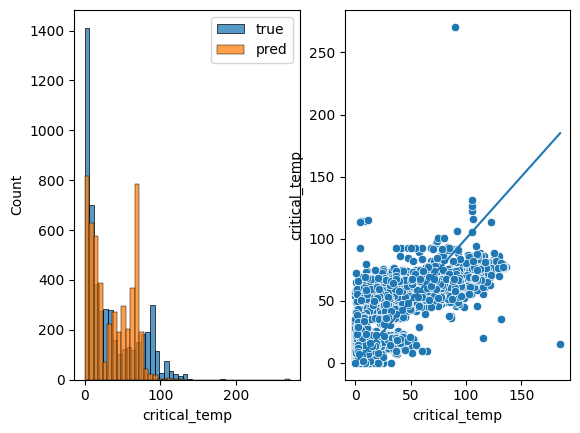

In [79]:
get_pred_plot(test[y_col], lasso.predict(test[X_col]), filter=True)

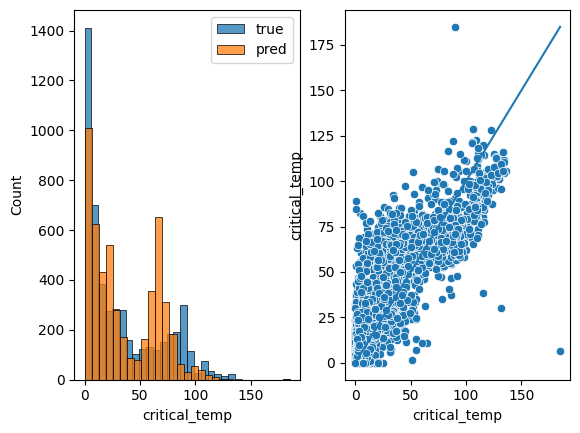

In [41]:
get_pred_plot(test[y_col], lm.predict(test[X_col]), filter=True)

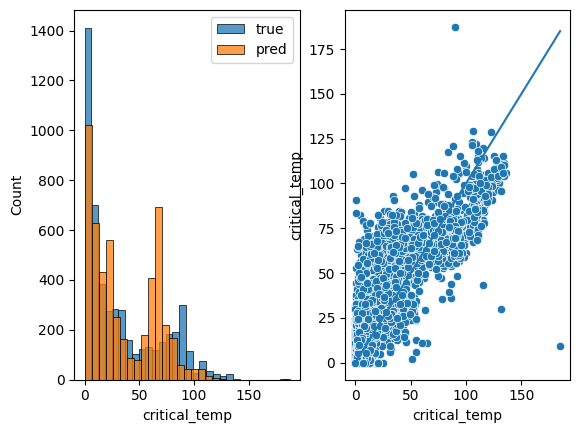

In [42]:
get_pred_plot(test[y_col], ridge.predict(test[X_col]), filter=True)

## Decision tree

In [80]:
valid, test = train_test_split(test, train_size=0.5, random_state=54152)

In [81]:
dt = DecisionTreeRegressor(max_depth=16, criterion='squared_error', min_samples_split=10)
dt.fit(train[X_col], train[y_col])

dt_metric = pd.concat([
    get_metric(train[y_col], dt.predict(train[X_col])),
    get_metric(valid[y_col], dt.predict(valid[X_col])),
    get_metric(test[y_col], dt.predict(test[X_col])),
])
dt_metric.index = ['dt_train', 'dt_valid', 'dt_test']
dt_metric

,MSE,RMSE,MAE,R2
dt_train,51.085757,7.147430,4.245250,0.956835
dt_valid,159.154035,12.615627,7.187634,0.862263
dt_test,142.310117,11.929380,6.683781,0.879342


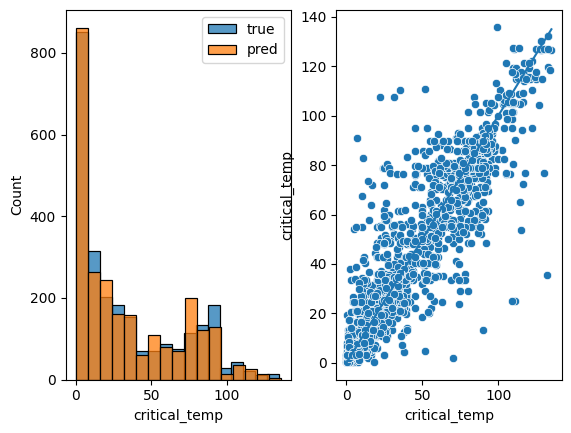

In [82]:
get_pred_plot(test[y_col], dt.predict(test[X_col]))

In [46]:
dt_fi = pd.DataFrame({
    'feature_name':dt.feature_names_in_,
    'importance':dt.feature_importances_
})
dt_fi.sort_values('importance', ascending=False)

,feature_name,importance
106,Cu,0.641002
73,gmean_Valence,0.062286
97,Ca,0.052625
131,Ba,0.030324
35,entropy_Density,0.011263
...,...,...
145,Lu,0.000000
153,Au,0.000000
152,Pt,0.000000
151,Ir,0.000000


In [47]:
dt_fi.merge(reg_coef, on='feature_name')[['feature_name', 'lasso_wi', 'importance']].sort_values('importance', ascending=False)

,feature_name,lasso_wi,importance
106,Cu,-0.00000,0.641002
73,gmean_Valence,0.00000,0.062286
97,Ca,0.00000,0.052625
131,Ba,5.38111,0.030324
35,entropy_Density,-0.00000,0.011263
...,...,...,...
145,Lu,0.00000,0.000000
153,Au,-0.00000,0.000000
152,Pt,0.00000,0.000000
151,Ir,-0.00000,0.000000


## CatBoost

In [9]:
boost = CatBoostRegressor(
    learning_rate=1e-2,
    max_depth=6,
    n_estimators=2000,
    verbose=100,
    random_state=1635
    )
boost.fit(train[X_col], train[y_col])

0:	learn: 34.1449289	total: 158ms	remaining: 5m 15s
100:	learn: 19.2097319	total: 847ms	remaining: 15.9s
200:	learn: 14.7702727	total: 1.49s	remaining: 13.4s
300:	learn: 13.2814594	total: 2.13s	remaining: 12s
400:	learn: 12.6128096	total: 2.77s	remaining: 11s
500:	learn: 12.2060912	total: 3.4s	remaining: 10.2s
600:	learn: 11.8844873	total: 4.05s	remaining: 9.44s
700:	learn: 11.6180158	total: 4.7s	remaining: 8.71s
800:	learn: 11.3788708	total: 5.36s	remaining: 8.03s
900:	learn: 11.1683682	total: 6.03s	remaining: 7.35s
1000:	learn: 10.9666508	total: 6.7s	remaining: 6.68s
1100:	learn: 10.7600780	total: 7.38s	remaining: 6.02s
1200:	learn: 10.5764396	total: 8.06s	remaining: 5.37s
1300:	learn: 10.4348384	total: 8.76s	remaining: 4.71s
1400:	learn: 10.2961533	total: 9.46s	remaining: 4.04s
1500:	learn: 10.1642981	total: 10.2s	remaining: 3.38s
1600:	learn: 10.0435939	total: 10.9s	remaining: 2.71s
1700:	learn: 9.9358119	total: 11.6s	remaining: 2.04s
1800:	learn: 9.8265637	total: 12.3s	remaining: 

In [13]:
cat_boost_metric = pd.concat([
    get_metric(train[y_col], boost.predict(train[X_col])),
    get_metric(valid[y_col], boost.predict(valid[X_col])),
    get_metric(test[y_col], boost.predict(test[X_col])),
])
cat_boost_metric.index = ['boost_train', 'boost_valid', 'boost_test']
cat_boost_metric

,MSE,RMSE,MAE,R2
boost_train,92.740582,9.630191,6.384448,0.921639
boost_valid,134.927881,11.615846,7.300266,0.883229
boost_test,124.054488,11.137975,6.997457,0.894820


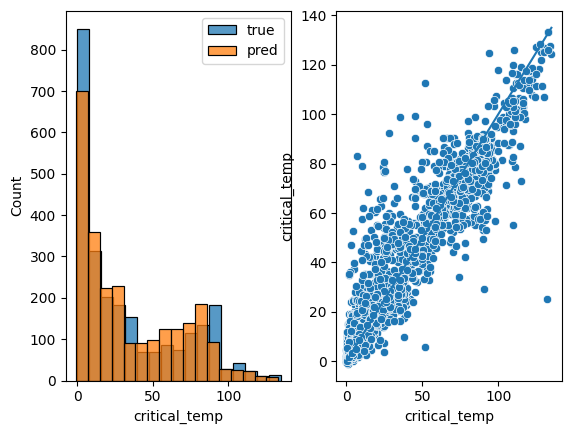

In [85]:
get_pred_plot(test[y_col], boost.predict(test[X_col]))

In [14]:
boost_fi = pd.DataFrame({
    'feature_name':boost.feature_names_,
    'importance':boost.feature_importances_
})
boost_fi.sort_values('importance', ascending=False)

,feature_name,importance
106,Cu,21.451976
97,Ca,8.158128
131,Ba,6.197244
74,wtd_gmean_Valence,3.723054
72,wtd_mean_Valence,3.023638
...,...,...
142,Er,0.000000
143,Tm,0.000000
153,Au,0.000000
150,Os,0.000000


In [26]:
predict_f = pd.read_csv('data/formula_test.csv')
predict_t = pd.read_csv('data/test.csv')

In [27]:
df_test =  pd.concat([predict_f, predict_t], axis=1)

drop_col = df_test.columns.difference(boost.feature_names_)

In [17]:
drop_col

Index(['Ar', 'At', 'He', 'Kr', 'Ne', 'Pm', 'Po', 'Rn', 'Xe', 'critical_temp',
       'material'],
      dtype='object')

In [28]:
df_test =  pd.concat([predict_f, predict_t], axis=1)
df_test = df_test[df_test.columns.drop(drop_col)]
df_test.shape

(4253, 158)

In [29]:
pred = pd.DataFrame({'critical_temp':boost.predict(df_test)})

In [35]:
pred.to_csv('predict.csv')

In [36]:
p = pd.read_csv('predict.csv')
p

,Unnamed: 0,critical_temp
0,0,24.475386
1,1,27.319881
2,2,60.536302
3,3,58.922168
4,4,64.680983
...,...,...
4248,4248,24.168767
4249,4249,4.500005
4250,4250,7.782443
4251,4251,4.866753


In [37]:
df_test.shape

(4253, 158)

In [38]:
p.shape

(4253, 2)

In [ ]:
126.5 ** (1/2)

11.247221879201993